# Omniglot Character Set Classification Using Prototypical Network 


Now we will see how to use prototypical networks to perform the classification task. We use omniglot dataset for performing classification. Omniglot dataset comprises of 1,623 handwritten characters from 50 different alphabets and each character has 20 different examples written by different people. Since we want our network to learn from little data, we train them in the same way. We sample five examples from each class and use that as our support set. We learn the embeddings of our support set using a sequence of four convolution blocks as our encoder and build the class prototype. Similarly, we sample five examples from each class for query set, learn the query set embeddings and predict the query set class by comparing the Euclidean distance between the query set embeddings and class prototype. Let us better understand this by going through it step by step.

First we import all the required libraries,

In [1]:
import os
import glob
from PIL import Image

import numpy as np
import tensorflow as tf

### Understanding the dataset

Now, we will explore and see what we got in our data. As we know we have different characters from different alphabets and each character has twenty different variants written by different people. Let's plot and check some of them. 

Let us plot one character from Japanese alphabet

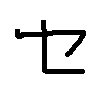

In [2]:
Image.open('data/images/Japanese_(katakana)/character13/0608_01.png')

the same alphabet in different variation

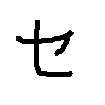

In [3]:
Image.open('data/images/Japanese_(katakana)/character13/0608_13.png')

Let us see sanskrit alphabet

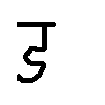

In [4]:
Image.open('data/images/Sanskrit/character13/0863_09.png')

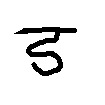

In [5]:
Image.open('data/images/Sanskrit/character13/0863_13.png')

How can we convert this image into an array? we can use np.array function to convert these images into an array and then we reshape it to 28*28

In [6]:
image_name = 'data/images/Sanskrit/character13/0863_13.png'
alphabet, character, rotation = 'Sanskrit/character13/rot000'.split('/')
rotation = float(rotation[3:])

In [7]:
np.array(Image.open(image_name).rotate(rotation).resize((28, 28)), np.float32,copy=True)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1

Now, that we have understood, what is in our dataset, let us load our dataset:

In [8]:
root_dir = 'data/'

We have the splitting details in the /data/omniglot/splits/train.txt file which has the language name, character number, rotation information and images in /data/omniglot/data/ directory.

In [9]:
train_split_path = os.path.join(root_dir, 'splits', 'train.txt')

with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]

In [10]:
#number of classes
no_of_classes = len(train_classes)

Now we set the number of examples to 20, as we have 20 example per class in our dataset, and also we set image width and height to 28 x 28:

In [11]:
#number of examples
num_examples = 20

#image width
img_width = 28

#image height
img_height = 28
channels = 1

Next, we initialize our training dataset with a shape as a number of classes, number of examples, image height and image width:

In [12]:
train_dataset = np.zeros([no_of_classes, num_examples, img_height, img_width], dtype=np.float32)

Now, we read all the images, convert it to numpy array and store it our train_dataset array with their label and values, that is,  train_dataset = [label, values]:

In [13]:
for label, name in enumerate(train_classes):
    alphabet, character, rotation = name.split('/')
    rotation = float(rotation[3:])
    img_dir = os.path.join(root_dir, 'data', alphabet, character)
    img_files = sorted(glob.glob(os.path.join(img_dir, '*.png')))
  
    
    for index, img_file in enumerate(img_files):
        values = 1. - np.array(Image.open(img_file).rotate(rotation).resize((img_width, img_height)), np.float32, copy=False)
        train_dataset[label, index] = values

In [14]:
train_dataset.shape

(4112, 20, 28, 28)

Now that we have loaded our training data, we need to create embeddings for them. We generate the embeddings using a convolution operation as our inputs are images. So, we define a convolutional block with 64 filters with batch normalization and ReLU as the activation function. Followed by we perform max pooling operation:

In [15]:
def convolution_block(inputs, out_channels, name='conv'):

    conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
    conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
    conv = tf.nn.relu(conv)
    conv = tf.contrib.layers.max_pool2d(conv, 2)
    
    return conv

Now, we define our embedding function which gives us the embedding comprising of four convolutional blocks:

In [16]:
def get_embeddings(support_set, h_dim, z_dim, reuse=False):

        net = convolution_block(support_set, h_dim)
        net = convolution_block(net, h_dim)
        net = convolution_block(net, h_dim) 
        net = convolution_block(net, z_dim) 
        net = tf.contrib.layers.flatten(net)
        
        return net

Remember, we don't use our whole dataset for training, since we are one shot learning, we sample some data points from each class as a support set and train the network using the support set in an episodic fashion. 


Now we define some of the important variables, we consider a 60-way 5-shot learning scenario:

In [17]:
#number of classes
num_way = 60  

#number of examples per class for support set
num_shot = 5  

#number of query points
num_query = 5 

#number of examples
num_examples = 20

h_dim = 64

z_dim = 64

Next, we initialize placeholders for our support set and query set:

In [18]:
support_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])
query_set = tf.placeholder(tf.float32, [None, None, img_height, img_width, channels])

And we store the shape of our support set and query set in support_set_shape and query_set_shape respectively:

In [19]:
support_set_shape = tf.shape(support_set)
query_set_shape = tf.shape(query_set)

Get the number of classes and number of data points in the support set and number of data points in the query set for initializing our support and query sets:

In [20]:
num_classes, num_support_points = support_set_shape[0], support_set_shape[1]

In [21]:
num_query_points = query_set_shape[1]

Next, we define the placeholder for our label:

In [22]:
y = tf.placeholder(tf.int64, [None, None])

#convert the label to one hot
y_one_hot = tf.one_hot(y, depth=num_classes)

Now, we generate the embeddings for our support set using our embedding function:

In [23]:
support_set_embeddings = get_embeddings(tf.reshape(support_set, [num_classes * num_support_points, img_height, img_width, channels]), h_dim, z_dim)

We compute the prototype of each class which is the mean vector of the support set embeddings of the class:

In [24]:
embedding_dimension = tf.shape(support_set_embeddings)[-1]

class_prototype = tf.reduce_mean(tf.reshape(support_set_embeddings, [num_classes, num_support_points, embedding_dimension]), axis=1)

Next, we use our same embedding function for getting embeddings of the query set:

In [25]:
query_set_embeddings = get_embeddings(tf.reshape(query_set, [num_classes * num_query_points, img_height, img_width, channels]), h_dim, z_dim, reuse=True)

Now that, we have the class prototype and query set embeddings, we define a distance function which gives us the distance between the class prototypes and query set embeddings:

In [26]:
def euclidean_distance(a, b):

    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)


Calculate the distance between the class prototype and query set embeddings:

In [27]:
distance = euclidean_distance(class_prototype,query_set_embeddings)

Next, we get the probability for each class as a softmax to the distance:

In [28]:
predicted_probability = tf.reshape(tf.nn.log_softmax(-distance), [num_classes, num_query_points, -1])

Compute the loss

In [29]:
loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, predicted_probability), axis=-1), [-1]))

Calculate accuracy

In [30]:
accuracy = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(predicted_probability, axis=-1), y)))

We use Adam optimizer for minimizing the loss:



In [31]:
train = tf.train.AdamOptimizer().minimize(loss)

Now, we start our tensorflow session and train the model,

In [32]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

In [33]:
num_epochs = 20
num_episodes = 100

In [ ]:
for epoch in range(num_epochs):
    
    for episode in range(num_episodes):
        
        # select 60 classes
        episodic_classes = np.random.permutation(no_of_classes)[:num_way]
        
        support = np.zeros([num_way, num_shot, img_height, img_width], dtype=np.float32)
        
        query = np.zeros([num_way, num_query, img_height, img_width], dtype=np.float32)
        
        
        for index, class_ in enumerate(episodic_classes):
            selected = np.random.permutation(num_examples)[:num_shot + num_query]
            support[index] = train_dataset[class_, selected[:num_shot]]
            
            # 5 querypoints per classs
            query[index] = train_dataset[class_, selected[num_shot:]]
            
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(num_way)[:, np.newaxis], (1, num_query)).astype(np.uint8)
        _, loss_, accuracy_ = sess.run([train, loss, accuracy], feed_dict={support_set: support, query_set: query, y:labels})
        
        if (episode+1) % 10 == 0:
            print('Epoch {} : Episode {} : Loss: {}, Accuracy: {}'.format(epoch+1, episode+1, loss_, accuracy_))

Epoch 1 : Episode 10 : Loss: 5.70378160477, Accuracy: 0.0166666675359
Epoch 1 : Episode 20 : Loss: 5.70378160477, Accuracy: 0.0166666675359
